# InfoGAN
InfoGAN은 기존 DCGAN과 달리 비지도학습에서 disentangled representation을 학습하는 구조입니다. 

> disentangled representation이란 차원의 축을 따라 꼬여있는 representation을 의미를 갖도록하는 거입니다. 예시로 검은색 신발과 회색 신발을 연결하는 선이 있다고 생각하면 편합니다.


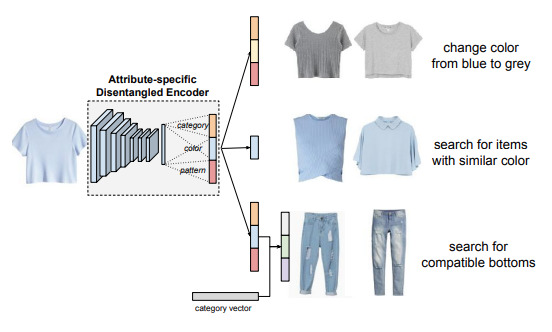 

<br>


 [이미지 출처](https://vaclavkosar.com/ml/manipulate-item-attributes-via-disentangled-representation)


 그러므로 MNIST 데이터셋을 학습한 InfoGAN은 기존 GAN과 달리 문자의 두께 같은 요소를 바꾸도록 조절이 가능 합니다. 혹은 CelebA 데이터셋을 학습한 모델 같은경우 머리 스타일, 성별을 바꾸기도 합니다. loss function에 잠재 코드 c, 생성자 모델의 분포 $G(z,c)$ 사이에 상호 정보량을 최대화 시키도록 하면 InfoGAN을 구현 할 수 있습니다.

  그렇기에 InfoGAN이 아닌 DCGAN 같은 경우는 아래와 같이 무분별하게 생성될 확률이 높습니다.

|DCGAN GIF|
|------|
|<img src='https://raw.githubusercontent.com/eriklindernoren/PyTorch-GAN/master/assets/dcgan.gif' alt="results.gif"/>|
[출처](https://github.com/eriklindernoren/PyTorch-GAN)

 하지만 InfoGAN은 다릅니다. 아래 이미지와 같이 같은 행에 같은 문자가 올지, 아니면 0~9까지 증가하는 순으로 둘지 결정할수 있습니다. 이뿐만 아니라 문자의 두께, 기울기 등도 잠재공간에서 변수를 이용해 조절할 수 있습니다.

 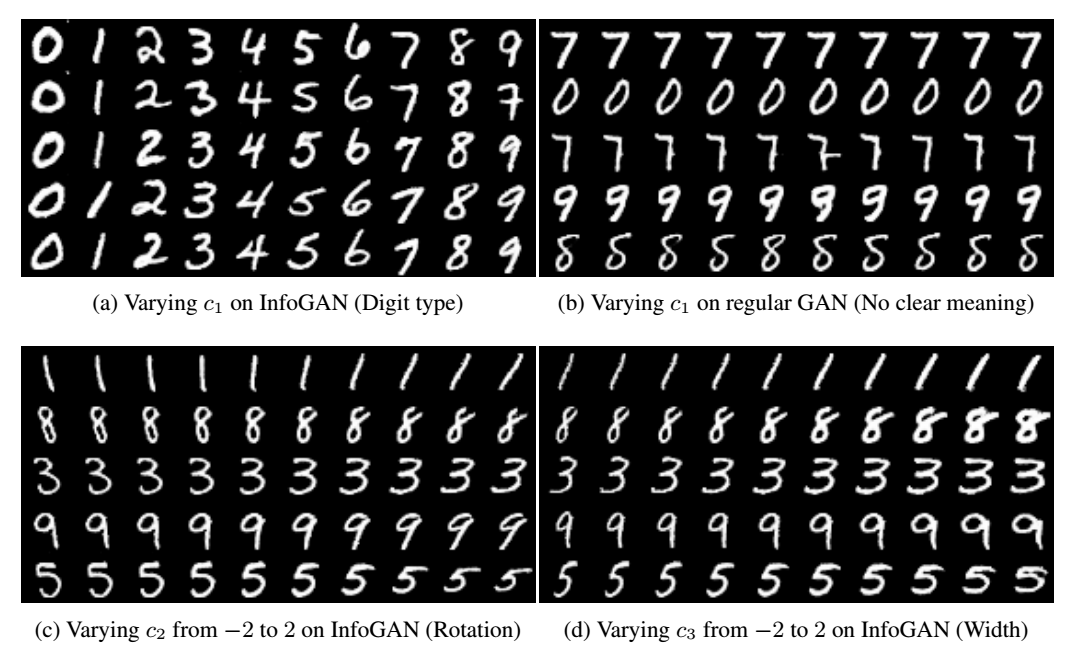

이렇든 잠재공간에서 조금씩 변화를 주어 이미지가 잘 변화하도록 하는 모델이 InfoGAN의 목적입니다.

# Imports

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import time
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset,DataLoader

In [ ]:
params={
    'epochs':100,
    'image_size':64,
    'batch_size':256,
    'num_workers':4,
    'nz':74,
    'nc':1,
    'ngf':64,
    'ndf':64,
    'lr':1e-3,
    'beta1':0.5,
    'pin_memory':True
}

In [ ]:
# get_data 함수는 FashionMNIST dataloader를 return합니다.
def get_data(batch_size,num_workers,pin_memory=False):
  p2d='./Fashion'

  train_ds=dset.FashionMNIST(
        root=p2d,
        train='train',
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((params['image_size'],params['image_size'])),
        ])
    )


  train_dl=DataLoader(
        train_ds,
        batch_size=batch_size,
        pin_memory=pin_memory,
        num_workers=num_workers
    )

  return train_dl

# 시각화

데이터셋에 64개 이미지를 시각화합니다. 이미지는 신발, 옷, 바지, 원피스 등 여러가지 패션과 관련된 이미지입니다. 저희 InfoGAN은 비슷한 이미지를 생성할 것입니다.

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./Fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./Fashion/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./Fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./Fashion/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./Fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./Fashion/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./Fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./Fashion/FashionMNIST/raw



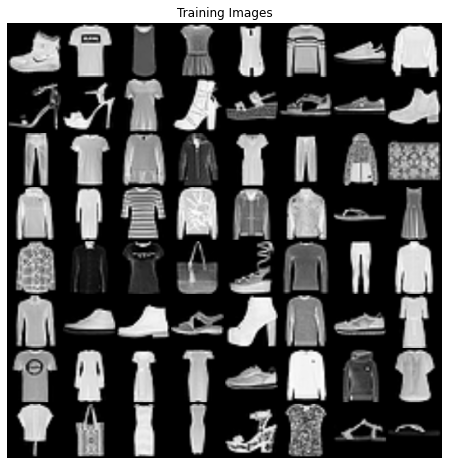

In [ ]:
To_tensor=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((params['image_size'],params['image_size'])),

])

dataloader=get_data(params['batch_size'],params['num_workers'],params['pin_memory'])


device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# 모델 선언
**G_conv, D_conv** : 생성자와 판별자 모델에 반복해서 쓰이는 Conv를 정리해놓은 클래스입니다.

**Generator, Discriminator** : 생성자와 판별자 모델입니다.

**QHead** : QHead는 모평균, 공변량 그리고 분별자의 logit을 모아둔 변수를 return합니다.

**DHead** : DHead는 Discriminator output에 추가적인 Conv와 Sigmoid를 적용합니다. Discriminator에 같이 포함할 수 있지만 Discriminator에는 가중치를 초기화 안하고 DHead에만 가중치를 초기화 합니다.

In [ ]:

class G_conv(nn.Module):
    def __init__(self,in_channels,out_channels,*args):
        super(G_conv,self).__init__()
        self.conv=nn.Sequential(
            nn.ConvTranspose2d( in_channels,out_channels,*args, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )
    def forward(self,x):
        return self.conv(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main=nn.Sequential(
            G_conv(params['nz'],params['ngf']*8,4,1,0),
            G_conv(params['ngf']*8,params['ngf']*4,4,2,1),
            G_conv(params['ngf']*4,params['ngf']*2,4,2,1),
            G_conv(params['ngf']*2,params['ngf'],4,2,1),

            nn.ConvTranspose2d(params['ngf'],params['nc'],4,2,1,bias=False),
            nn.Tanh()
        )
    
    def forward(self,x):
        return self.main(x)

class D_conv(nn.Module):
    def __init__(self,in_channels,out_channels,*args):
        super(D_conv,self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels, out_channels, *args, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self,x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(params['nc'],params['ndf'],4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            D_conv(params['ndf'],params['ndf']*2,4,2,1),
            D_conv(params['ndf']*2,params['ndf']*4,4,2,1),
            D_conv(params['ndf']*4,params['ndf']*8,4,2,1),
            nn.Conv2d(params['ndf']*8,params['ndf']*8,4,1,0,bias=False),
        )

    def forward(self,x):
        return self.main(x)

class DHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv=nn.Conv2d(params['ndf']*8,1,1,bias=False)
    
    def forward(self,x):
        x=torch.sigmoid(self.conv(x))
        return x
class QHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(params['ndf']*8,128,1,bias=False)
        self.bn1=nn.BatchNorm2d(128)
        self.leakyrelu=nn.LeakyReLU(0.2,inplace=True)
        self.conv_disc=nn.Conv2d(128,10,1)
        self.conv_mu=nn.Conv2d(128,2,1)
        self.conv_var=nn.Conv2d(128,2,1)

    def forward(self,x):
        x=self.leakyrelu(self.bn1(self.conv1(x)))
        
        disc_logits=self.conv_disc(x).squeeze()

        mu=self.conv_mu(x).squeeze()
        var=torch.exp(self.conv_var(x).squeeze())

        return disc_logits,mu,var

**weights_init** : 가중치 초기화에 사용됩니다.

**NormalNLLLoss** :정규분포의 음의 가능도를 계산합니다. Factored Gaussian으로 $Q(c_j|x)$를 다룹니다.

**noise_sample** : 학습에 필요한 랜덤한 노이즈 벡터를 생성합니다.


In [ ]:
def weights_init(m):
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif isinstance(m,nn.BatchNorm2d):
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

class NormalNLLLoss:
    def __call__(self,x,mu,var):
        logli=-0.5*(var.mul(2*np.pi)+1e-6).log()-(x-mu).pow(2).div(var.mul(2.0)+1e-6)
        nll=-(logli.sum(1).mean())

        return nll

def noise_sample(n_dis_c,dis_c_dim,n_con_c,n_z,batch_size,device):
    z=torch.randn(batch_size,n_z,1,1,device=device)

    idx=np.zeros((n_dis_c,batch_size))
    if n_dis_c !=0:
        dis_c=torch.zeros(batch_size,n_dis_c,dis_c_dim,device=device)

        for i in range(n_dis_c):
            idx[i]=np.random.randint(dis_c_dim,size=batch_size)
            dis_c[torch.arange(0,batch_size),i,idx[i]]=1.0
        
        dis_c=dis_c.view(batch_size,-1,1,1)

    if n_con_c!=0:
        con_c=torch.rand(batch_size,n_con_c,1,1,device=device)*2-1

    noise=z

    if n_dis_c!=0:
        noise=torch.cat((z,dis_c),dim=1)
    if n_con_c!=0:
        noise=torch.cat((noise,con_c),dim=1)
    return noise,idx

# Train

In [ ]:
params['num_z']=62
params['num_dis_c']=1
params['dis_c_dim']=10
params['num_con_c']=2

device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')

netG=Generator().to(device)
discriminator=Discriminator().to(device)
netD=DHead().to(device)
netQ=QHead().to(device)

netG.apply(weights_init)
netD.apply(weights_init)
netQ.apply(weights_init)

criterionD=nn.BCELoss()
criterionQ_dis=nn.CrossEntropyLoss()
criterionQ_con=NormalNLLLoss()

fixed_noise=torch.randn(64,params['nz'],1,1,device=device)


optimD=optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}],lr=params['lr'],betas=(params['beta1'],0.999))
optimG=optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}],lr=params['lr'],betas=(params['beta1'],0.999))

#fixed noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label=1.
fake_label=0.

img_list=[]
G_losses=[]
D_losses=[]

iters=0
print('start')
for epoch in range(params['epochs']):
    epoch_start_time = time.time()
    for i, (data,_) in enumerate(dataloader,0):
        b_size=data.size(0)
        real_data=data.to(device)

        optimD.zero_grad()
        label=torch.full((b_size,),real_label,device=device)
        output1=discriminator(real_data)
        probs_real=netD(output1).view(-1)
        loss_real=criterionD(probs_real,label)
        loss_real.backward()

        label.fill_(fake_label)
        noise,idx=noise_sample(params['num_dis_c'],params['dis_c_dim'],params['num_con_c'],params['num_z'],b_size,device)
        fake_data=netG(noise)
        output2=discriminator(fake_data.detach())
        probs_fake=netD(output2).view(-1)
        loss_fake=criterionD(probs_fake,label)

        loss_fake.backward()

        D_loss=loss_real+loss_fake
        optimD.step()
        optimG.zero_grad()

        output=discriminator(fake_data)
        label.fill_(real_label)
        probs_fake=netD(output).view(-1)
        gen_loss=criterionD(probs_fake,label)

        q_logits,q_mu,q_var=netQ(output)
        target=torch.LongTensor(idx).to(device)

        dis_loss=0
        for j in range(params['num_dis_c']):
            dis_loss+=criterionQ_dis(q_logits[:,j*10:j*10+10],target[j])

        con_loss=0
        if params['num_con_c']!=0:
            con_loss=criterionQ_con(noise[:,params['num_z']+params['num_dis_c']*params['dis_c_dim']:].view(-1,params['num_con_c']),q_mu,q_var)*0.1
        G_loss=gen_loss+dis_loss+con_loss
        G_loss.backward()
        optimG.step()
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['epochs'], i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        iters += 1

        # loss를 plotting하기 위해 저장합니다.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))

    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))
    # 처음, 학습 중간일때 그리고 10번마다 생성된 이미지를 저장합니다.
    if((epoch+1) == 1 or (epoch+1) == params['epochs']/2) or epoch%10==0:
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format('Generation Image') %(epoch+1))
        plt.close('all')



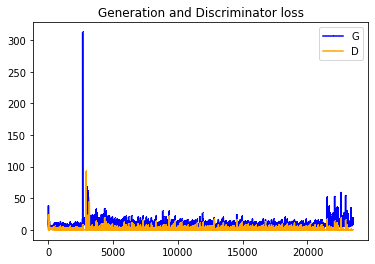

In [ ]:
# 생성자와 분별자의 loss를 시각화합니다.
plt.figure()
plt.plot(G_losses, color='blue', marker=',', label='G')
plt.plot(D_losses, color='orange', marker=',', label='D')
plt.title('Generation and Discriminator loss')
plt.legend()
plt.show()


# Result

이미지가 잘 생성되었습니다. InfoGAN을 이용해 FashionMNIST 뿐만 아닌 다양한 이미지도 생성할 수 있습니다. 

|Generation GIF|Generation Image|
|------|--------|
|<img src='https://github.com/cjfghk5697/Paper_Implementation/blob/main/GAN/InfoGAN/results/FashionMNIST/result.gif' alt="results.gif"/>|<img src='https://github.com/cjfghk5697/Paper_Implementation/blob/main/GAN/InfoGAN/results/FashionMNIST/4.png' alt="results.gif"/>|

위 사진을 본다면 같은 행에  신발만 있는 걸 확인 할 수 있습니다. 왜냐하면 같은 축에 있는 이미지들을 한 행에 시각화해서입니다.

이미지를 자동으로 생성해주는 GAN에 관심이 간다면 [Pytorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN)에서 다양한 GAN 코드들을 확인하는 걸 강력 추천 드립니다.